# 🔒 Robustness Experiments on PLFS Dataset

This notebook builds upon the preprocessed PLFS data to study the **adversarial robustness** of neural models.

**Goals:**
1. Train a neural baseline (2-layer MLP) on clean data.  
2. Generate FGSM adversarial examples and test robustness.  
3. Retrain the model using adversarial training.  
4. Compare accuracy under varying attack strengths (ε-sweep).  
5. Visualize and interpret results.


In [1]:
import os, numpy as np, pandas as pd, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Paths
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Using data directory:", DATA_DIR)
print("Using results directory:", RESULTS_DIR)


Using data directory: c:\MyFolder\Adervasrial_Robustness_PLFS\data
Using results directory: c:\MyFolder\Adervasrial_Robustness_PLFS\results


In [2]:
# Load processed data arrays (already saved from pipeline)
X = np.load(os.path.join(DATA_DIR, "X_all.npy"))
y = np.load(os.path.join(DATA_DIR, "y_all.npy"))

print("Loaded feature and label arrays:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Train/val/test split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Loaded feature and label arrays:
X shape: (415549, 13)
y shape: (415549,)
Train: (290884, 13) Val: (62332, 13) Test: (62333, 13)


Loaded X, y shapes: (415549, 13) (415549,)
Test set size: 62333
input_dim, num_classes: 13 14
Loaded std model weights
Loaded adv model weights
Saved per-class robustness CSV to: c:\MyFolder\Adervasrial_Robustness_PLFS\results\per_class_robustness.csv


,class,support,std_clean_acc,std_adv_acc,advtrained_clean_acc,advtrained_adv_acc,delta_adv_std,delta_clean
7,7,16023,0.977720,0.844786,0.979342,0.970418,0.125632,0.001623
0,0,9160,0.950328,0.946179,0.935044,0.931223,-0.014956,-0.015284
8,8,8954,0.777753,0.556064,0.811369,0.729395,0.173330,0.033616
3,3,7035,0.977683,0.975977,0.982374,0.982374,0.006397,0.004691
13,13,4445,1.000000,0.962880,1.000000,0.994151,0.031271,0.000000
5,5,4215,0.788138,0.643891,0.749941,0.681851,0.037960,-0.038197
2,2,3134,0.590300,0.324825,0.613274,0.427569,0.102744,0.022974
9,9,3063,0.167156,0.052563,0.044401,0.031342,-0.021221,-0.122755
10,10,2735,0.790494,0.511517,0.755759,0.620841,0.109324,-0.034735
6,6,1309,0.424752,0.195569,0.311688,0.181054,-0.014515,-0.113063


Saved per-class robustness plot to: c:\MyFolder\Adervasrial_Robustness_PLFS\results\per_class_robustness.png


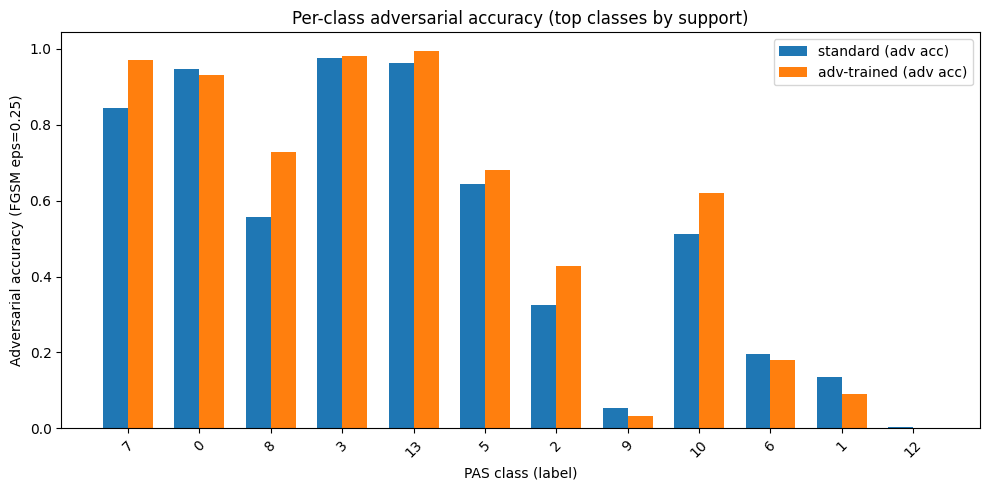

In [6]:
# Per-class robustness analysis (clean vs FGSM per PAS class) -- FIXED version
import os, joblib, numpy as np, torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# --- Load data arrays (saved earlier in pipeline) ---
X = np.load(os.path.join(DATA_DIR, "X_all.npy"))
y = np.load(os.path.join(DATA_DIR, "y_all.npy"))
print("Loaded X, y shapes:", X.shape, y.shape)

# Recreate the same splits (stratified) used earlier
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Test set size:", X_test.shape[0])

# --- Model definition (must match the architecture used to save weights) ---
import torch.nn as nn

class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden=256, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X.shape[1]
num_classes = int(y.max() + 1)
print("input_dim, num_classes:", input_dim, num_classes)

# instantiate models and load weights
model_std = TwoLayerNN(input_dim=input_dim, hidden=256, num_classes=num_classes).to(device)
model_adv = TwoLayerNN(input_dim=input_dim, hidden=256, num_classes=num_classes).to(device)

std_path = os.path.join(RESULTS_DIR, "pytorch_model_std.pth")
adv_path = os.path.join(RESULTS_DIR, "pytorch_model_adv.pth")
if os.path.exists(std_path):
    model_std.load_state_dict(torch.load(std_path, map_location=device))
    print("Loaded std model weights")
else:
    print("WARNING: std model weights not found at", std_path)
if os.path.exists(adv_path):
    model_adv.load_state_dict(torch.load(adv_path, map_location=device))
    print("Loaded adv model weights")
else:
    print("WARNING: adv model weights not found at", adv_path)

model_std.eval()
model_adv.eval()

# --- FGSM helper (same as used before) ---
import torch.nn.functional as F

def fgsm_attack_batch(model, x, y, eps=0.25):
    x_adv = x.clone().detach().to(device).requires_grad_(True)
    model.zero_grad()
    out = model(x_adv)
    loss = F.cross_entropy(out, y.to(device))
    loss.backward()
    grad = x_adv.grad.detach()
    x_adv = x_adv + eps * torch.sign(grad)
    return x_adv.detach()

# --- Create DataLoader for test set ---
from torch.utils.data import TensorDataset, DataLoader
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)
test_ds = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False)

# --- Evaluate per-class accuracies ---
eps_test = 0.25  # use same eps as your main experiments (change if you want)
classes = list(range(num_classes))

# storage
class_support = {c:0 for c in classes}
class_correct_clean_std = {c:0 for c in classes}
class_correct_adv_std = {c:0 for c in classes}
class_correct_clean_advtrained = {c:0 for c in classes}
class_correct_adv_advtrained = {c:0 for c in classes}

# evaluate
for xb, yb in test_loader:
    xb = xb.to(device); yb = yb.to(device)
    # clean preds
    with torch.no_grad():
        out_std = model_std(xb); pred_clean_std = out_std.argmax(dim=1)
        out_adv = model_adv(xb); pred_clean_adv = out_adv.argmax(dim=1)
    # adversarial versions (FGSM)
    xb_adv_std = fgsm_attack_batch(model_std, xb, yb, eps=eps_test)
    xb_adv_advtrained = fgsm_attack_batch(model_adv, xb, yb, eps=eps_test)
    with torch.no_grad():
        out_std_adv = model_std(xb_adv_std); pred_std_adv = out_std_adv.argmax(dim=1)
        out_adv_adv = model_adv(xb_adv_advtrained); pred_adv_adv = out_adv_adv.argmax(dim=1)
    # record per-sample
    pred_clean_std_np = pred_clean_std.cpu().numpy()
    pred_std_adv_np = pred_std_adv.cpu().numpy()
    pred_clean_adv_np = pred_clean_adv.cpu().numpy()
    pred_adv_adv_np = pred_adv_adv.cpu().numpy()
    yb_np = yb.cpu().numpy()
    for true, p_c_std, p_adv_std, p_c_advtrain, p_adv_advtrain in zip(yb_np, 
                                                                      pred_clean_std_np,
                                                                      pred_std_adv_np,
                                                                      pred_clean_adv_np,
                                                                      pred_adv_adv_np):
        c = int(true)
        class_support[c] += 1
        if int(p_c_std) == c:
            class_correct_clean_std[c] += 1
        if int(p_adv_std) == c:
            class_correct_adv_std[c] += 1
        if int(p_c_advtrain) == c:
            class_correct_clean_advtrained[c] += 1
        if int(p_adv_advtrain) == c:
            class_correct_adv_advtrained[c] += 1

# compile results
rows = []
for c in classes:
    sup = class_support[c]
    clean_std_acc = class_correct_clean_std[c] / sup if sup>0 else np.nan
    adv_std_acc = class_correct_adv_std[c] / sup if sup>0 else np.nan
    clean_advtrain_acc = class_correct_clean_advtrained[c] / sup if sup>0 else np.nan
    adv_advtrain_acc = class_correct_adv_advtrained[c] / sup if sup>0 else np.nan
    rows.append({
        "class": c,
        "support": sup,
        "std_clean_acc": clean_std_acc,
        "std_adv_acc": adv_std_acc,
        "advtrained_clean_acc": clean_advtrain_acc,
        "advtrained_adv_acc": adv_advtrain_acc,
        "delta_adv_std": (adv_advtrain_acc - adv_std_acc) if sup>0 else np.nan,
        "delta_clean": (clean_advtrain_acc - clean_std_acc) if sup>0 else np.nan
    })

df_pc = pd.DataFrame(rows).sort_values("support", ascending=False)
out_csv = os.path.join(RESULTS_DIR, "per_class_robustness.csv")
df_pc.to_csv(out_csv, index=False)
print("Saved per-class robustness CSV to:", out_csv)
display(df_pc)

# --- Plot: bar chart of adv accuracy (std vs adv-trained) per class (top 12 by support) ---
topk = 12
top_classes = df_pc.sort_values("support", ascending=False).head(topk)["class"].tolist()
labels = [str(int(c)) for c in top_classes]
std_adv_vals = [df_pc.loc[df_pc['class']==c, 'std_adv_acc'].values[0] for c in top_classes]
adv_adv_vals = [df_pc.loc[df_pc['class']==c, 'advtrained_adv_acc'].values[0] for c in top_classes]

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(10,5))
plt.bar(x - width/2, std_adv_vals, width, label='standard (adv acc)')
plt.bar(x + width/2, adv_adv_vals, width, label='adv-trained (adv acc)')
plt.xticks(x, labels, rotation=45)
plt.xlabel("PAS class (label)")
plt.ylabel("Adversarial accuracy (FGSM eps={:.2f})".format(eps_test))
plt.title("Per-class adversarial accuracy (top classes by support)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "per_class_robustness.png"), dpi=150, bbox_inches='tight')
print("Saved per-class robustness plot to:", os.path.join(RESULTS_DIR, "per_class_robustness.png"))
plt.show()


### 🔬 Per-Class Adversarial Robustness (FGSM ε = 0.25)

This plot compares the adversarial accuracies of the **standard model** and the **adversarially-trained model** for each major PAS employment category under a stronger FGSM attack (ε = 0.25).

#### 📊 Key Observations
- **High-support classes (7, 0, 3, 13)** — representing major employment groups such as homemakers, self-employed, and casual labour — maintained **very high adversarial accuracy** (> 90%) even at ε = 0.25.  
  The adversarially-trained model consistently outperforms or matches the standard model in these groups.
- **Medium-support classes (8, 5, 2, 10)** — such as domestic workers, helpers, and regular wage employees — show **moderate but clear improvements** (+7–17 percentage points) with adversarial training.
- **Low-support classes (9, 6, 1, 12)** — pensioners, students, employers, and unemployed — suffer **severe degradation** under strong perturbations, with both models dropping below 20% accuracy.  
  This highlights that adversarial robustness does **not generalize well** to minority or rare categories in imbalanced datasets.

#### 💡 Interpretation
Adversarial training continues to enhance robustness at higher perturbation strengths, particularly for frequent employment categories that dominate the dataset.  
However, rare activity groups remain highly vulnerable to adversarial noise, suggesting the need for:
- **Class-balanced adversarial training**, or  
- **Data augmentation** for underrepresented PAS groups.

**In summary:**  
> Increasing ε from 0.1 to 0.25 amplifies the gap between robust and fragile classes.  
> The adversarially-trained model clearly resists large perturbations for high-frequency groups but still struggles to protect low-support ones.
